In [ ]:
# Requirements
!pip install tensorflow_datasets flax jax optax tqdm netket imgaug==0.2.6

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import jax
import jax.numpy as jnp
import jax
import flax
import netket as nk
import jax.numpy as jnp
from jax.experimental import stax
import optax
from flax.training import train_state  # Useful dataclass to keep train state
from functools import partial
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

### Utility Functions

In [ ]:
def show_img(img, ax=None, title=None):
  """Shows a single image.
  
  Must be stored as a 3d-tensor where the last dimension is 1 channel (greyscale)
  """
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[..., 0], cmap='gray')
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    show_img(img, axs[i // n][i % n], title)

##Setting up the dataset


In [ ]:
#import
ds_builder = tfds.builder('mnist')
ds_builder.download_and_prepare()
train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
# Normalize
train_ds['image'] = jnp.float32(train_ds['image']) / 255.
test_ds['image'] = jnp.float32(test_ds['image']) / 255.
print("dataset keys:", train_ds.keys())
print(f"The training dataset has shape: {train_ds['image'].shape} and dtype {train_ds['image'].dtype}")
print(f"The test     dataset has shape: {test_ds['image'].shape} and dtype {train_ds['image'].dtype}")
print("")
print(f"The training labels have shape: {train_ds['label'].shape} and dtype {train_ds['label'].dtype}")
print(f"The test     labels have shape: {test_ds['label'].shape} and dtype {test_ds['label'].dtype}")
print("The mean     of the data stored in the images are: ", np.mean(train_ds['image']))
print("The variance of the data stored in the images are: ", np.var(train_ds['image']))

dataset keys: dict_keys(['image', 'label'])
The training dataset has shape: (60000, 28, 28, 1) and dtype float32
The test     dataset has shape: (10000, 28, 28, 1) and dtype float32

The training labels have shape: (60000,) and dtype int64
The test     labels have shape: (10000,) and dtype int64
The mean     of the data stored in the images are:  0.13066046
The variance of the data stored in the images are:  0.09493043


##Non-linearities

In [ ]:
def modRelu(z, bias): # relu(|z|+b) * (z / |z|)
    norm = jnp.abs(z)
    scale = nk.nn.relu(norm + bias) / (norm + 1e-6)
    scaled = jax.lax.complex(jnp.real(z)*scale, jnp.imag(z)*scale)
    return scaled

In [ ]:
def complex_relu(z):
    return jnp.where(z.real > 0, z, 0)
complex_relu = jax.jit(complex_relu)
modRelu=jax.jit(modRelu)

In [ ]:
def zrelu(z, epsilon=1e-7):
    """
    zReLU presented in "On Complex Valued Convolutional Neural Networks"
        from Nitzan Guberman (2016).
    This methods let's the output as the input if both real and imaginary parts are positive.
    https://stackoverflow.com/questions/49412717/advanced-custom-activation-function-in-keras-tensorflow
    """
    imag_relu = jax.nn.relu(z.imag)
    real_relu = jax.nn.relu(z.real)
    ret_real = imag_relu*real_relu / (imag_relu + epsilon)
    ret_imag = imag_relu*real_relu / (real_relu + epsilon)
    ret_val = ret_real + 1j * ret_imag
    return ret_val

In [ ]:
def complex_cardioid(z):
    """
    Complex cardioid presented in "Better than Real: Complex-valued Neural Nets for MRI Fingerprinting"
        from V. Patrick (2017).
        
    This function maintains the phase information while attenuating the magnitude based on the phase itself. 
    For real-valued inputs, it reduces to the ReLU.
    """
    return ((1 + jnp.cos(jnp.angle(z))) + 0j) * z / 2.

## Define Model

In [ ]:
# You can add a fft layer here. You can have up to 2. It is better to put them at the beginning or at the end
class Model(nk.nn.Module):
  n_classes : int = 10
  @nk.nn.compact
  def __call__(self, x, train):
    #make rng for dropoutlayer
    dropout_rng = self.make_rng('dropout')

    #first convolutions 3x3 --> 32. Avgpol 2x2 stride 2x2
    x = nk.nn.Conv(features=32, kernel_size=(3, 3), dtype=complex)(x)
    x = complex_relu(x)
    x = flax.linen.avg_pool(x, window_shape=(2, 2), strides=(2, 2)) 
    
    #second convolution 3x3 -->64. Avgpol 2x2 stride 2x2
    x = nk.nn.Conv(features=64, kernel_size=(3, 3), dtype=complex)(x)
    x = flax.linen.Dropout(0.5, deterministic=not train)(x) #DROPOUT 1
    x = complex_relu(x)
    x = flax.linen.avg_pool(x, window_shape=(2, 2), strides=(2, 2))

    #flatten and dense
    x = x.reshape((x.shape[0], -1))
    x = nk.nn.Dense(features=256, dtype=complex)(x)
    x = complex_relu(x)

    #DROPOUT 2
    x = flax.linen.Dropout(0.5, deterministic=not train)(x) 

    #dense2 and softmax
    x = nk.nn.Dense(features=10, dtype=complex)(x)    # There are 10 classes in MNIST
    x = jnp.abs(x)
    x = nk.nn.log_softmax(x)

    return x

## Loss functions

In [ ]:
# The loss function that we will use
def cross_entropy(*, logits, labels):
    one_hot_labels = jax.nn.one_hot(labels, num_classes=10)
    return -jnp.mean(jnp.sum(one_hot_labels * logits, axis=-1))

In [ ]:
dropout_rng, init_dropout = jax.random.split(jax.random.PRNGKey(1))


In [ ]:
def loss_fn(params, dropout_rng, images, labels):
    """
    Loss function minimised during training of the model.
    """
    logits = model.apply(params, images, rngs={'dropout' : dropout_rng}, train=True)
    return cross_entropy(logits=logits, labels=labels)

def compute_metrics(*, logits, labels):
    """
    Compute metrics of the model during training.
    
    Returns the loss and the accuracy.
    """
    loss = cross_entropy(logits=logits, labels=labels)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    metrics = {
      'loss': loss,
      'accuracy': accuracy,
    }
    return metrics

## 4 - Create the setup and training loop


In [ ]:
def create_train_state(rng, optimiser, dropout_rng):
    """Creates initial `TrainState`, holding the current parameters, state of the
    optimiser and other metadata.
    """
    # Construct the model parameters
    params = model.init({'params' : rng, 'dropout' : dropout_rng}, jnp.ones([1, 28, 28, 1]), train=True)
        
    # Package all those informations in the model state
    return train_state.TrainState.create(
        apply_fn=model.apply, params=params, tx=optimiser)


In [ ]:
@jax.jit
def eval_metrics(params, batch, dropout_rng):
    """
    This function evaluates the metrics without training the model.
    
    Used to check the performance of the network on training and test datasets.
    """
    logits = model.apply(params, batch['image'], rngs={'dropout' : dropout_rng}, train=False)
    return compute_metrics(logits=logits, labels=batch['label'])

In [ ]:
def fgsm_update(image, data_grad, update_max_norm):
    """
    update the adversarial pictures given original ones, gradient and norm
    """
    # Collect the element-wise sign of the data gradient
    sign_data_grad = jnp.sign(data_grad)
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + update_max_norm*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = jnp.clip(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [ ]:
def loss_fn2(images, params, dropout_rng, labels):
    """
    Loss function minimised during training of the model.
    """
    logits = model.apply(params, images, rngs={'dropout' : dropout_rng}, train=True)
    return cross_entropy(logits=logits, labels=labels)


In [ ]:
@jax.jit
def train_step(state, batch, dropout_rng):
    """
    Train for a single step.
    
    """
    #Make parameters the only 'free' parameter
    _loss_fn = partial(loss_fn, dropout_rng = dropout_rng, images=batch['image'], labels=batch['label'])
    # construct the function returning the loss value and gradient.
    val_grad_fn = jax.value_and_grad(_loss_fn)
    # compute loss and gradient
    loss, grads = val_grad_fn(state.params)
    grads = jax.tree_map(lambda x: x.conj(), grads) 
    # update the state parameters 
    state = state.apply_gradients(grads=grads)

    # Generate adversarial examples
    _loss_fn2 = partial(loss_fn2, params=state.params, dropout_rng = dropout_rng, labels=batch['label'])
    grad = jax.grad(_loss_fn2)
    g = grad(batch['image'])
    for epsilon in [0.2]:
      new_images = fgsm_update(batch['image'], g, epsilon)
      # Train on these
      _loss_fn3 = partial(loss_fn, dropout_rng = dropout_rng, images=new_images, labels=batch['label'])
      val_grad_fn3 = jax.value_and_grad(_loss_fn3)
      loss, grads = val_grad_fn3(state.params)
      grads = jax.tree_map(lambda x: x.conj(), grads) 
      state = state.apply_gradients(grads=grads)
    # Evaluate the network again to get the log-probability distribution
    # over the batch images
    metrics = eval_metrics(state.params, batch, dropout_rng)
    
    return state, metrics

In [ ]:
def train_epoch(state, train_ds, batch_size, epoch, rng, dropout_rng, *, max_steps=None):
    """Train an epoch.
     """
    
    # total number of training images
    train_ds_size = len(train_ds['image'])
    
    # Compute how many steps are present in this epoch.
    steps_per_epoch = train_ds_size // batch_size

    # Truncate the number of steps
    if max_steps is not None:
        steps_per_epoch = min(steps_per_epoch, max_steps)

    # generate a random permutation of the indices to shuffle the training
    perms = jax.random.permutation(rng, train_ds_size)
    perms = perms[:steps_per_epoch * batch_size]
    perms = perms.reshape((steps_per_epoch, batch_size))
    
    # execute the training step for every mini-batch
    batch_metrics = []
    for perm in perms:
        batch = {k: v[perm, ...] for k, v in train_ds.items()}
        state, metrics = train_step(state, batch, dropout_rng)
        batch_metrics.append(metrics)

    # compute mean of metrics across each batch in epoch.
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
            for k in batch_metrics_np[0]}

    return state, epoch_metrics_np


def evaluate_model(params, test_ds, dropout_rng):
    """
    evaluate the performance of the model on the test dataset
    """
    metrics = eval_metrics(params, test_ds, dropout_rng)
    metrics = jax.device_get(metrics)
    summary = jax.tree_map(lambda x: x.item(), metrics)
    return summary['loss'], summary['accuracy']

# 5 - Training model

In [ ]:
models_saved = []
for s in range(0, 10):
  # Definition of optimiser HyperParameters
  learning_rate = 0.0005
  momentum = 0.9
  optimiser = optax.sgd(learning_rate, momentum)
  num_epochs = 10
  batch_size = 32
  max_steps = 200

  #define rngs
  seed = s #123
  seed_dropout = 10-s #0
  key = {'params': jax.random.PRNGKey(seed), 'dropout': jax.random.PRNGKey(seed_dropout)}

  #init model
  model = Model(n_classes=10)
  sample_input = jnp.ones([1, 28, 28, 1])
  pars = model.init(key, sample_input, train=True)

  # Split the rng to get two keys, one to 'shuffle' the dataset at every iteration,
  # and one to initialise the network
  rng, init_rng = jax.random.split(jax.random.PRNGKey(s))

  state = create_train_state(init_rng, optimiser, init_dropout)
  metrics = {"test_loss" : [], "test_accuracy": [], "train_loss":[], "train_accuracy":[]}
  with tqdm(range(1, num_epochs + 1)) as pbar:
      for epoch in pbar:
          # Use a separate PRNG key to permute image data during shuffling
          rng, input_rng = jax.random.split(rng)
          dropout_rng, _ = jax.random.split(dropout_rng)
          # Run an optimization step over a training batch
          state, train_metrics = train_epoch(state, train_ds, batch_size, epoch, input_rng, dropout_rng)
          
          # Evaluate on the test set after each training epoch
          test_loss, test_accuracy = evaluate_model(state.params, test_ds, dropout_rng)
          pbar.write('train epoch: %d, loss: %.4f, accuracy: %.2f' % (epoch, train_metrics['loss'], train_metrics['accuracy'] * 100))
          pbar.write(' test epoch: %d, loss: %.2f, accuracy: %.2f' % (epoch, test_loss, test_accuracy * 100))

          # save data
          metrics["train_loss"].append(train_metrics["loss"])
          metrics["train_accuracy"].append(train_metrics["accuracy"])
          metrics["test_loss"].append(test_loss)
          metrics["test_accuracy"].append(test_accuracy)

  models_saved += [state]

  0%|          | 0/10 [00:00<?, ?it/s]

train epoch: 1, loss: 0.7397, accuracy: 84.33
 test epoch: 1, loss: 0.24, accuracy: 94.73
train epoch: 2, loss: 0.1706, accuracy: 95.68
 test epoch: 2, loss: 0.13, accuracy: 96.44
train epoch: 3, loss: 0.1160, accuracy: 96.73
 test epoch: 3, loss: 0.09, accuracy: 97.76
train epoch: 4, loss: 0.0931, accuracy: 97.26
 test epoch: 4, loss: 0.09, accuracy: 97.31
train epoch: 5, loss: 0.0776, accuracy: 97.65
 test epoch: 5, loss: 0.09, accuracy: 97.37
train epoch: 6, loss: 0.0665, accuracy: 98.03
 test epoch: 6, loss: 0.06, accuracy: 98.00
train epoch: 7, loss: 0.0604, accuracy: 98.19
 test epoch: 7, loss: 0.05, accuracy: 98.30
train epoch: 8, loss: 0.0562, accuracy: 98.32
 test epoch: 8, loss: 0.05, accuracy: 98.38
train epoch: 9, loss: 0.0526, accuracy: 98.37
 test epoch: 9, loss: 0.05, accuracy: 98.43
train epoch: 10, loss: 0.0486, accuracy: 98.52
 test epoch: 10, loss: 0.05, accuracy: 98.27


  0%|          | 0/10 [00:00<?, ?it/s]

train epoch: 1, loss: 0.7505, accuracy: 82.86
 test epoch: 1, loss: 0.24, accuracy: 93.18
train epoch: 2, loss: 0.1738, accuracy: 95.08
 test epoch: 2, loss: 0.13, accuracy: 96.11
train epoch: 3, loss: 0.1185, accuracy: 96.50
 test epoch: 3, loss: 0.10, accuracy: 96.93
train epoch: 4, loss: 0.0970, accuracy: 97.09
 test epoch: 4, loss: 0.08, accuracy: 97.49
train epoch: 5, loss: 0.0832, accuracy: 97.46
 test epoch: 5, loss: 0.07, accuracy: 97.65
train epoch: 6, loss: 0.0744, accuracy: 97.76
 test epoch: 6, loss: 0.06, accuracy: 97.95
train epoch: 7, loss: 0.0774, accuracy: 97.68
 test epoch: 7, loss: 0.08, accuracy: 97.50
train epoch: 8, loss: 0.0722, accuracy: 97.84
 test epoch: 8, loss: 0.07, accuracy: 97.65
train epoch: 9, loss: 0.0760, accuracy: 97.70
 test epoch: 9, loss: 0.07, accuracy: 97.62
train epoch: 10, loss: 0.0599, accuracy: 98.20
 test epoch: 10, loss: 0.05, accuracy: 98.11


  0%|          | 0/10 [00:00<?, ?it/s]

train epoch: 1, loss: 0.8693, accuracy: 80.32
 test epoch: 1, loss: 0.25, accuracy: 94.65
train epoch: 2, loss: 0.1774, accuracy: 95.29
 test epoch: 2, loss: 0.11, accuracy: 96.86
train epoch: 3, loss: 0.1127, accuracy: 96.74
 test epoch: 3, loss: 0.09, accuracy: 97.38
train epoch: 4, loss: 0.0957, accuracy: 97.14
 test epoch: 4, loss: 0.08, accuracy: 97.53
train epoch: 5, loss: 0.0773, accuracy: 97.59
 test epoch: 5, loss: 0.07, accuracy: 97.70
train epoch: 6, loss: 0.0696, accuracy: 97.84
 test epoch: 6, loss: 0.06, accuracy: 97.89
train epoch: 7, loss: 0.0606, accuracy: 98.10
 test epoch: 7, loss: 0.05, accuracy: 98.15
train epoch: 8, loss: 0.0553, accuracy: 98.33
 test epoch: 8, loss: 0.05, accuracy: 98.16
train epoch: 9, loss: 0.0505, accuracy: 98.47
 test epoch: 9, loss: 0.05, accuracy: 98.43
train epoch: 10, loss: 0.0516, accuracy: 98.43
 test epoch: 10, loss: 0.06, accuracy: 98.10


  0%|          | 0/10 [00:00<?, ?it/s]

train epoch: 1, loss: 0.8690, accuracy: 79.91
 test epoch: 1, loss: 0.24, accuracy: 94.19
train epoch: 2, loss: 0.1697, accuracy: 95.61
 test epoch: 2, loss: 0.12, accuracy: 96.80
train epoch: 3, loss: 0.1067, accuracy: 96.84
 test epoch: 3, loss: 0.08, accuracy: 97.57
train epoch: 4, loss: 0.0840, accuracy: 97.45
 test epoch: 4, loss: 0.07, accuracy: 97.69
train epoch: 5, loss: 0.0724, accuracy: 97.75
 test epoch: 5, loss: 0.07, accuracy: 97.88
train epoch: 6, loss: 0.0635, accuracy: 98.00
 test epoch: 6, loss: 0.06, accuracy: 98.00
train epoch: 7, loss: 0.0596, accuracy: 98.18
 test epoch: 7, loss: 0.05, accuracy: 98.33
train epoch: 8, loss: 0.0535, accuracy: 98.32
 test epoch: 8, loss: 0.05, accuracy: 98.26
train epoch: 9, loss: 0.0483, accuracy: 98.50
 test epoch: 9, loss: 0.05, accuracy: 98.33
train epoch: 10, loss: 0.0455, accuracy: 98.62
 test epoch: 10, loss: 0.05, accuracy: 98.39


  0%|          | 0/10 [00:00<?, ?it/s]

train epoch: 1, loss: 0.8128, accuracy: 82.08
 test epoch: 1, loss: 0.29, accuracy: 93.61
train epoch: 2, loss: 0.1949, accuracy: 94.53
 test epoch: 2, loss: 0.13, accuracy: 95.98
train epoch: 3, loss: 0.1292, accuracy: 96.24
 test epoch: 3, loss: 0.10, accuracy: 96.74
train epoch: 4, loss: 0.0985, accuracy: 97.04
 test epoch: 4, loss: 0.08, accuracy: 97.28
train epoch: 5, loss: 0.0791, accuracy: 97.62
 test epoch: 5, loss: 0.08, accuracy: 97.47
train epoch: 6, loss: 0.0712, accuracy: 97.82
 test epoch: 6, loss: 0.06, accuracy: 97.98
train epoch: 7, loss: 0.0667, accuracy: 98.01
 test epoch: 7, loss: 0.07, accuracy: 97.71
train epoch: 8, loss: 0.0630, accuracy: 98.00
 test epoch: 8, loss: 0.05, accuracy: 98.32
train epoch: 9, loss: 0.0554, accuracy: 98.31
 test epoch: 9, loss: 0.05, accuracy: 98.34
train epoch: 10, loss: 0.0511, accuracy: 98.43
 test epoch: 10, loss: 0.07, accuracy: 97.88


  0%|          | 0/10 [00:00<?, ?it/s]

train epoch: 1, loss: 0.8997, accuracy: 79.40
 test epoch: 1, loss: 0.30, accuracy: 93.78
train epoch: 2, loss: 0.1957, accuracy: 95.53
 test epoch: 2, loss: 0.13, accuracy: 96.87
train epoch: 3, loss: 0.1148, accuracy: 96.91
 test epoch: 3, loss: 0.11, accuracy: 96.89
train epoch: 4, loss: 0.0875, accuracy: 97.39
 test epoch: 4, loss: 0.10, accuracy: 97.24
train epoch: 5, loss: 0.0739, accuracy: 97.83
 test epoch: 5, loss: 0.06, accuracy: 97.84
train epoch: 6, loss: 0.0659, accuracy: 98.00
 test epoch: 6, loss: 0.06, accuracy: 98.17
train epoch: 7, loss: 0.0604, accuracy: 98.18
 test epoch: 7, loss: 0.05, accuracy: 98.23
train epoch: 8, loss: 0.0579, accuracy: 98.26
 test epoch: 8, loss: 0.05, accuracy: 98.46
train epoch: 9, loss: 0.0565, accuracy: 98.25
 test epoch: 9, loss: 0.07, accuracy: 97.93
train epoch: 10, loss: 0.0538, accuracy: 98.41
 test epoch: 10, loss: 0.05, accuracy: 98.44


  0%|          | 0/10 [00:00<?, ?it/s]

train epoch: 1, loss: 0.8287, accuracy: 81.56
 test epoch: 1, loss: 0.24, accuracy: 94.63
train epoch: 2, loss: 0.1706, accuracy: 95.50
 test epoch: 2, loss: 0.12, accuracy: 96.69
train epoch: 3, loss: 0.1096, accuracy: 96.77
 test epoch: 3, loss: 0.08, accuracy: 97.50
train epoch: 4, loss: 0.0886, accuracy: 97.30
 test epoch: 4, loss: 0.08, accuracy: 97.62
train epoch: 5, loss: 0.0728, accuracy: 97.79
 test epoch: 5, loss: 0.06, accuracy: 98.07
train epoch: 6, loss: 0.0658, accuracy: 97.99
 test epoch: 6, loss: 0.06, accuracy: 97.96
train epoch: 7, loss: 0.0601, accuracy: 98.15
 test epoch: 7, loss: 0.05, accuracy: 98.24
train epoch: 8, loss: 0.0564, accuracy: 98.26
 test epoch: 8, loss: 0.05, accuracy: 98.29
train epoch: 9, loss: 0.0570, accuracy: 98.28
 test epoch: 9, loss: 0.05, accuracy: 98.21
train epoch: 10, loss: 0.0549, accuracy: 98.28
 test epoch: 10, loss: 0.05, accuracy: 98.43


  0%|          | 0/10 [00:00<?, ?it/s]

train epoch: 1, loss: 0.8979, accuracy: 78.33
 test epoch: 1, loss: 0.24, accuracy: 95.17
train epoch: 2, loss: 0.1648, accuracy: 95.68
 test epoch: 2, loss: 0.11, accuracy: 96.90
train epoch: 3, loss: 0.1053, accuracy: 96.88
 test epoch: 3, loss: 0.10, accuracy: 96.82
train epoch: 4, loss: 0.0903, accuracy: 97.36
 test epoch: 4, loss: 0.07, accuracy: 97.76
train epoch: 5, loss: 0.0786, accuracy: 97.63
 test epoch: 5, loss: 0.07, accuracy: 97.80
train epoch: 6, loss: 0.0702, accuracy: 97.79
 test epoch: 6, loss: 0.06, accuracy: 98.25
train epoch: 7, loss: 0.0683, accuracy: 97.91
 test epoch: 7, loss: 0.06, accuracy: 97.92
train epoch: 8, loss: 0.0701, accuracy: 97.83
 test epoch: 8, loss: 0.07, accuracy: 97.89
train epoch: 9, loss: 0.0640, accuracy: 98.00
 test epoch: 9, loss: 0.06, accuracy: 98.09
train epoch: 10, loss: 0.0600, accuracy: 98.15
 test epoch: 10, loss: 0.06, accuracy: 98.12


  0%|          | 0/10 [00:00<?, ?it/s]

train epoch: 1, loss: 0.9180, accuracy: 79.06
 test epoch: 1, loss: 0.27, accuracy: 93.71
train epoch: 2, loss: 0.1892, accuracy: 94.84
 test epoch: 2, loss: 0.13, accuracy: 96.17
train epoch: 3, loss: 0.1303, accuracy: 96.12
 test epoch: 3, loss: 0.10, accuracy: 96.85
train epoch: 4, loss: 0.1050, accuracy: 96.78
 test epoch: 4, loss: 0.08, accuracy: 97.46
train epoch: 5, loss: 0.0816, accuracy: 97.50
 test epoch: 5, loss: 0.07, accuracy: 97.87
train epoch: 6, loss: 0.0704, accuracy: 97.87
 test epoch: 6, loss: 0.06, accuracy: 98.06
train epoch: 7, loss: 0.0637, accuracy: 98.00
 test epoch: 7, loss: 0.05, accuracy: 98.19
train epoch: 8, loss: 0.0575, accuracy: 98.22
 test epoch: 8, loss: 0.05, accuracy: 98.31
train epoch: 9, loss: 0.0517, accuracy: 98.40
 test epoch: 9, loss: 0.05, accuracy: 98.40
train epoch: 10, loss: 0.0478, accuracy: 98.56
 test epoch: 10, loss: 0.05, accuracy: 98.37


  0%|          | 0/10 [00:00<?, ?it/s]

train epoch: 1, loss: 0.8119, accuracy: 80.72
 test epoch: 1, loss: 0.27, accuracy: 93.06
train epoch: 2, loss: 0.1785, accuracy: 94.88
 test epoch: 2, loss: 0.13, accuracy: 96.16
train epoch: 3, loss: 0.1093, accuracy: 96.78
 test epoch: 3, loss: 0.09, accuracy: 97.23
train epoch: 4, loss: 0.0899, accuracy: 97.29
 test epoch: 4, loss: 0.07, accuracy: 97.90
train epoch: 5, loss: 0.0767, accuracy: 97.66
 test epoch: 5, loss: 0.06, accuracy: 98.18
train epoch: 6, loss: 0.0696, accuracy: 97.83
 test epoch: 6, loss: 0.06, accuracy: 98.03
train epoch: 7, loss: 0.0703, accuracy: 97.88
 test epoch: 7, loss: 0.06, accuracy: 98.20
train epoch: 8, loss: 0.0768, accuracy: 97.68
 test epoch: 8, loss: 0.07, accuracy: 97.84
train epoch: 9, loss: 0.0713, accuracy: 97.84
 test epoch: 9, loss: 0.06, accuracy: 97.94
train epoch: 10, loss: 0.0602, accuracy: 98.17
 test epoch: 10, loss: 0.05, accuracy: 98.41


In [ ]:
#computing the number of parameters
tot_params = 0
for chiave in models_saved[0].params['params'].keys():
  for sotto_chiave in models_saved[0].params['params'][chiave]:
    print(chiave, ' \t', 
          sotto_chiave, '  \t', 
          models_saved[0].params['params'][chiave][sotto_chiave].size, '    \t', 
          models_saved[0].params['params'][chiave][sotto_chiave].dtype)
    tot_params += models_saved[0].params['params'][chiave][sotto_chiave].size
print('tot: (2*complex_params)', 2*tot_params)

Conv_0  	 bias   	 32     	 complex128
Conv_0  	 kernel   	 288     	 complex128
Conv_1  	 bias   	 64     	 complex128
Conv_1  	 kernel   	 18432     	 complex128
Dense_0  	 bias   	 256     	 complex128
Dense_0  	 kernel   	 802816     	 complex128
Dense_1  	 bias   	 10     	 complex128
Dense_1  	 kernel   	 2560     	 complex128
tot: (2*complex_params) 1648916


In [ ]:
#save the parameters using pickle
import pickle
models_params = [m.params for m in models_saved]
with open("complex_robust_many.txt", "wb") as fp:   #Pickling
  pickle.dump(models_params, fp)

Text(0, 0.5, 'Accuracy')

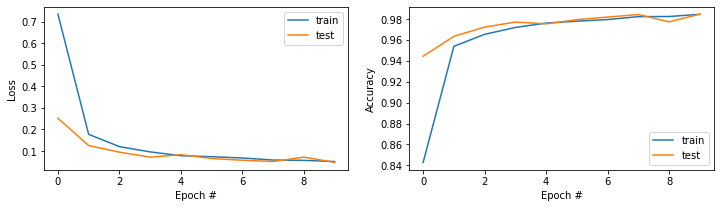

In [ ]:
#visualize losses
fig, axs = plt.subplots(1,2, figsize=(12,3))
axs[0].plot(metrics["train_loss"], label="train")
axs[0].plot(metrics["test_loss"], label="test")
axs[0].legend()
axs[0].set_xlabel("Epoch #")
axs[0].set_ylabel("Loss")


axs[1].plot(metrics["train_accuracy"], label="train")
axs[1].plot(metrics["test_accuracy"], label="test")
axs[1].legend()
axs[1].set_xlabel("Epoch #")
axs[1].set_ylabel("Accuracy")

## 6 Performing attack

In [ ]:
def loss_fn2(images, params, dropout_rng, labels):
    """
    Loss function minimised during training of the model.
    """
    # compute the output of the model, which gives the 
    # log-probability distribution over the possible classes (0...9)
    logits = model.apply(params, images, rngs={'dropout' : dropout_rng}, train=True)
    # feed it to the cross_entropy
    return cross_entropy(logits=logits, labels=labels)


In [ ]:
def fgsm_full_data(eps, parameters):
  new_images = jnp.empty((0,28,28,1))
  for i in range(10):
    batch = test_ds['image'][1000*i : 1000 * (i+1)]
    _loss_fn2 = partial(loss_fn2, params=parameters, dropout_rng = dropout_rng, labels=test_ds['label'][1000*i : 1000 * (i+1)])
    grad = jax.grad(_loss_fn2)
    g = grad(batch)
    batch = fgsm_update(batch, g, eps)
    new_images = jnp.vstack((new_images, batch))
    
  return new_images

In [ ]:
for_plot = []
for i, m in enumerate(models_saved):
  print(i, 'th training')
  accuracies_attack = []
  noise_amplitude = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
  for eps in noise_amplitude:
    print('eps =', eps)
    new_images = fgsm_full_data(eps, m.params)
    logits_with_fgsm = model.apply(m.params, new_images, rngs={'dropout' : dropout_rng}, train=False)
    metrics = compute_metrics(logits=logits_with_fgsm, labels=test_ds['label'])
    print(metrics)
    accuracies_attack +=  [metrics['accuracy']]
  print(i, 'th training')
  for_plot += [accuracies_attack]

0 th training
eps = 0.1
{'loss': DeviceArray(0.02529533, dtype=float64), 'accuracy': DeviceArray(0.9915, dtype=float64)}
eps = 0.2
{'loss': DeviceArray(0.01162663, dtype=float64), 'accuracy': DeviceArray(0.9965, dtype=float64)}
eps = 0.3
{'loss': DeviceArray(0.03287111, dtype=float64), 'accuracy': DeviceArray(0.9901, dtype=float64)}
eps = 0.4
{'loss': DeviceArray(0.12334625, dtype=float64), 'accuracy': DeviceArray(0.9589, dtype=float64)}
eps = 0.5
{'loss': DeviceArray(0.3556371, dtype=float64), 'accuracy': DeviceArray(0.8795, dtype=float64)}
eps = 0.6
{'loss': DeviceArray(0.63475424, dtype=float64), 'accuracy': DeviceArray(0.7913, dtype=float64)}
eps = 0.7
{'loss': DeviceArray(0.99417391, dtype=float64), 'accuracy': DeviceArray(0.693, dtype=float64)}
eps = 0.8
{'loss': DeviceArray(1.29702238, dtype=float64), 'accuracy': DeviceArray(0.6359, dtype=float64)}
eps = 0.9
{'loss': DeviceArray(1.56364092, dtype=float64), 'accuracy': DeviceArray(0.606, dtype=float64)}
eps = 1.0
{'loss': DeviceA

In [ ]:
#save the data for the plots
import pickle
with open("robust_complex_models_forplot.txt", "wb") as fp:   #Pickling
  pickle.dump(for_plot, fp)

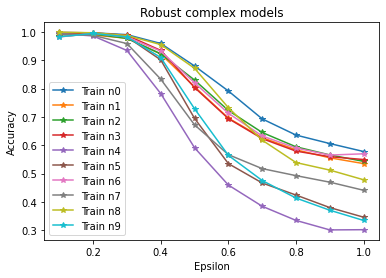

In [ ]:
#plot the results
for i in range(10):
  plt.plot(noise_amplitude, for_plot[i], "*-",  label='Train n'+str(i))
plt.legend()
plt.title("Robust complex models")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend();

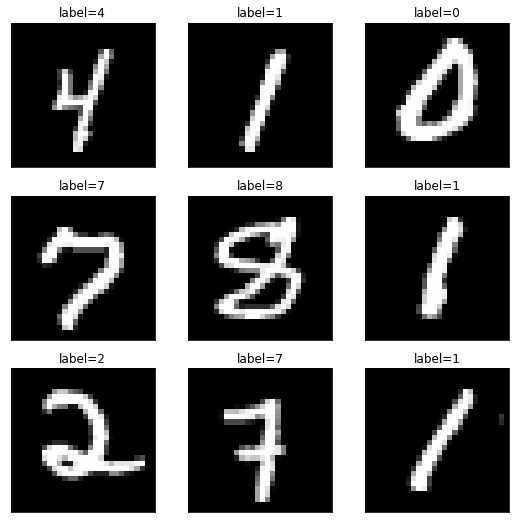

In [ ]:
#plot unperturbed pictures
show_img_grid(
    [train_ds['image'][idx] for idx in range(9)],
    [f'label={train_ds["label"][idx]}' for idx in range(9)],
)

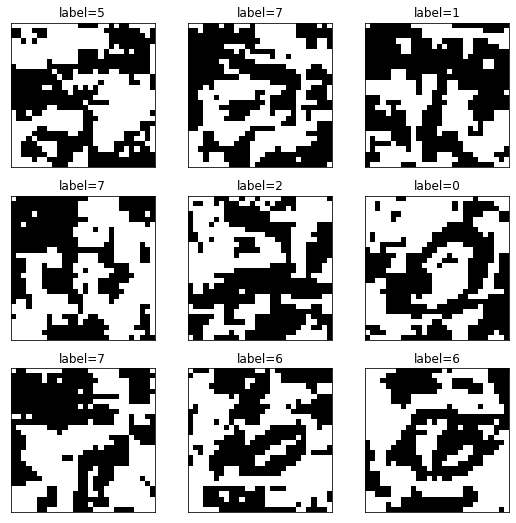

In [ ]:
#plot corrupted images
test = new_images
show_img_grid(
    [test[1000+idx] for idx in range(9)],
    [f'label={test_ds["label"][1000+idx]}' for idx in range(9)],
)